# Volatility Regime Framework
This project's goal is to adjust equity and risk positions based on existing regime changes in volatility mapped from the SPX and VIX indices

Shawn Chen

In [17]:
# CELL 1 — Setup / Imports / Helpers

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

try:
    import yfinance as yf
except ImportError as e:
    raise ImportError("yfinance not installed. Run: pip install yfinance") from e


def _to_single_close(df: pd.DataFrame, ticker: str) -> pd.Series:
    """
    Robustly extract a Close series from yfinance output, handling:
    - Single ticker columns (e.g., ['Open','High','Low','Close',...])
    - MultiIndex columns (e.g., ('Close','SPY') or ('SPY','Close') depending on yf version)
    """
    if isinstance(df.columns, pd.MultiIndex):
        # Try common MultiIndex layouts
        if ("Close", ticker) in df.columns:
            s = df[("Close", ticker)]
        elif (ticker, "Close") in df.columns:
            s = df[(ticker, "Close")]
        else:
            # fallback: search for a level that contains 'Close'
            close_cols = [c for c in df.columns if "Close" in c]
            if len(close_cols) == 0:
                raise KeyError(f"Could not find Close column for {ticker} in MultiIndex columns.")
            # if multiple, try to choose the one matching ticker
            for c in close_cols:
                if ticker in c:
                    s = df[c]
                    break
            else:
                s = df[close_cols[0]]
    else:
        if "Close" not in df.columns:
            raise KeyError(f"'Close' not found in columns for {ticker}. Columns: {df.columns.tolist()}")
        s = df["Close"]

    s = pd.to_numeric(s, errors="coerce")
    s.name = ticker
    return s


In [18]:
# CELL 2 — Download & Align (SPY + VIX), producing df with columns: ['spy', 'vix']

START = "2000-01-01"
END = None  # or "2025-12-31"

EQUITY_TICKER = "SPY"
VIX_TICKER = "^VIX"

raw = yf.download(
    tickers=[EQUITY_TICKER, VIX_TICKER],
    start=START,
    end=END,
    auto_adjust=True,
    progress=False,
    group_by="column",
)

spy = _to_single_close(raw, EQUITY_TICKER).rename("spy")
vix = _to_single_close(raw, VIX_TICKER).rename("vix")

df = pd.concat([spy, vix], axis=1).dropna()
df = df[~df.index.duplicated(keep="first")].sort_index()

df.head()


,spy,vix
Date,,
2000-01-03,91.617043,24.209999
2000-01-04,88.034264,27.010000
2000-01-05,88.191742,26.410000
2000-01-06,86.774414,25.730000
2000-01-07,91.813858,21.719999


In [19]:
# CELL 3 — Features (returns, forward returns) + Regime creation (guarantees df['regime'] exists)

# returns
df["ret"] = df["spy"].pct_change()

# forward returns (simple forward pct changes)
df["fwd_1d"]  = df["ret"].shift(-1)
df["fwd_5d"]  = df["spy"].pct_change(5).shift(-5)
df["fwd_20d"] = df["spy"].pct_change(20).shift(-20)

# regime definition (fixed thresholds)
LOW_THR = 15
HIGH_THR = 25

def regime_fixed(v):
    if pd.isna(v):
        return np.nan
    if v < LOW_THR:
        return "LOW"
    elif v < HIGH_THR:
        return "MID"
    else:
        return "HIGH"

df["regime"] = df["vix"].apply(regime_fixed)

# final clean
df = df.dropna(subset=["ret", "fwd_1d", "fwd_5d", "fwd_20d", "regime"])

df[["spy", "vix", "ret", "fwd_1d", "fwd_5d", "fwd_20d", "regime"]].head()


,spy,vix,ret,fwd_1d,fwd_5d,fwd_20d,regime
Date,,,,,,,
2000-01-04,88.034264,27.010000,-0.039106,0.001789,0.033989,0.009392,HIGH
2000-01-05,88.191742,26.410000,0.001789,-0.016071,0.021875,0.022768,HIGH
2000-01-06,86.774414,25.730000,-0.016071,0.058075,0.052631,0.035163,HIGH
2000-01-07,91.813858,21.719999,0.058075,0.003431,0.008363,-0.023155,MID
2000-01-10,92.128899,21.709999,0.003431,-0.011966,-0.002992,-0.013248,MID


In [20]:
# CELL 4 — Hard guards + quick sanity diagnostics (fail fast)

required = ["spy", "vix", "ret", "fwd_1d", "fwd_5d", "fwd_20d", "regime"]
missing = [c for c in required if c not in df.columns]
assert not missing, f"Missing columns in df: {missing}"

print("Rows:", len(df))
print("Date range:", df.index.min().date(), "->", df.index.max().date())
print("\nRegime counts:")
print(df["regime"].value_counts(dropna=False))
print("\nHead:")
display(df.head())


Rows: 6518
Date range: 2000-01-04 -> 2025-12-02

Regime counts:
regime
MID     3180
LOW     2080
HIGH    1258
Name: count, dtype: int64

Head:


,spy,vix,ret,fwd_1d,fwd_5d,fwd_20d,regime
Date,,,,,,,
2000-01-04,88.034264,27.010000,-0.039106,0.001789,0.033989,0.009392,HIGH
2000-01-05,88.191742,26.410000,0.001789,-0.016071,0.021875,0.022768,HIGH
2000-01-06,86.774414,25.730000,-0.016071,0.058075,0.052631,0.035163,HIGH
2000-01-07,91.813858,21.719999,0.058075,0.003431,0.008363,-0.023155,MID
2000-01-10,92.128899,21.709999,0.003431,-0.011966,-0.002992,-0.013248,MID


In [21]:
# CELL 5 — Optional: alternative regime methods (fixed vs percentile vs rolling z-score)
# This cell creates df["regime_alt"] without breaking df["regime"].

REGIME_METHOD = "fixed"  # choose: "fixed", "percentile", "zscore"
LOW_THR = 15
HIGH_THR = 25

PCTL_LOW = 0.33
PCTL_HIGH = 0.67

ZSCORE_WINDOW = 252
ZSCORE_LOW = -0.5
ZSCORE_HIGH = 0.5

def make_regime_fixed(v: float, low=LOW_THR, high=HIGH_THR):
    if pd.isna(v): return np.nan
    if v < low: return "LOW"
    if v < high: return "MID"
    return "HIGH"

def make_regime_percentile(v: float, low_cut: float, high_cut: float):
    if pd.isna(v): return np.nan
    if v < low_cut: return "LOW"
    if v < high_cut: return "MID"
    return "HIGH"

def make_regime_from_z(z: float, low=ZSCORE_LOW, high=ZSCORE_HIGH):
    if pd.isna(z): return np.nan
    if z < low: return "LOW"
    if z < high: return "MID"
    return "HIGH"

if REGIME_METHOD == "fixed":
    df["regime_alt"] = df["vix"].apply(make_regime_fixed)

elif REGIME_METHOD == "percentile":
    low_cut = df["vix"].quantile(PCTL_LOW)
    high_cut = df["vix"].quantile(PCTL_HIGH)
    df["regime_alt"] = df["vix"].apply(lambda x: make_regime_percentile(x, low_cut, high_cut))

elif REGIME_METHOD == "zscore":
    vix_mean = df["vix"].rolling(ZSCORE_WINDOW).mean()
    vix_std = df["vix"].rolling(ZSCORE_WINDOW).std()
    df["vix_z"] = (df["vix"] - vix_mean) / vix_std
    df["regime_alt"] = df["vix_z"].apply(make_regime_from_z)

else:
    raise ValueError(f"Unknown REGIME_METHOD: {REGIME_METHOD}")

# Choose which regime column you want downstream
REGIME_COL = "regime_alt"  # set to "regime" to use fixed thresholds
assert REGIME_COL in df.columns

# Clean: keep only rows with the chosen regime
df2 = df.dropna(subset=[REGIME_COL]).copy()

print("Using regime column:", REGIME_COL)
print(df2[REGIME_COL].value_counts())


Using regime column: regime_alt
regime_alt
MID     3180
LOW     2080
HIGH    1258
Name: count, dtype: int64


In [22]:
# CELL 6 — Performance summary by regime

horizons = ["fwd_1d", "fwd_5d", "fwd_20d"]

summary = (
    df2
    .groupby(REGIME_COL)[horizons]
    .agg(["mean", "std", "count"])
    .sort_index()
)

display(summary)


fwd_1d                    fwd_5d                   fwd_20d                
                mean       std count      mean       std count      mean       std count
regime_alt                                                                              
HIGH        0.000925  0.021701  1258  0.004236  0.040761  1258  0.016661  0.069230  1258
LOW         0.000294  0.005709  2080  0.001237  0.013640  2080  0.006442  0.028788  2080
MID         0.000239  0.009926  3180  0.001347  0.021742  3180  0.004253  0.043585  3180

In [23]:
# CELL 7 — Convert means into annualized intuition (optional but useful)
# Note: these are simple approximations using mean forward returns, not log returns.

ANN_FACTOR = 252

def ann_from_daily_mean(x):  # approx
    return (1 + x) ** ANN_FACTOR - 1

ann = pd.DataFrame(index=summary.index)
ann["ann_mean_from_fwd_1d"] = summary[("fwd_1d", "mean")].apply(ann_from_daily_mean)

# For 5d and 20d, back out an approximate daily mean first
ann["ann_mean_from_fwd_5d"] = ((1 + summary[("fwd_5d", "mean")]) ** (ANN_FACTOR/5)) - 1
ann["ann_mean_from_fwd_20d"] = ((1 + summary[("fwd_20d", "mean")]) ** (ANN_FACTOR/20)) - 1

display(ann)


,ann_mean_from_fwd_1d,ann_mean_from_fwd_5d,ann_mean_from_fwd_20d
regime_alt,,,
HIGH,0.262271,0.237436,0.231455
LOW,0.076788,0.064286,0.084270
MID,0.062096,0.070198,0.054926


In [24]:
# CELL 8 — Regime transition matrix (Markov-style)

reg = df2[REGIME_COL].astype("category")
reg_next = reg.shift(-1)

trans_counts = pd.crosstab(reg, reg_next, dropna=True)
trans_probs = trans_counts.div(trans_counts.sum(axis=1), axis=0)

print("Transition counts:")
display(trans_counts)
print("Transition probabilities:")
display(trans_probs)


Transition counts:


regime_alt,HIGH,LOW,MID
regime_alt,,,
HIGH,1128,0,130
LOW,0,1922,158
MID,129,158,2892


Transition probabilities:


regime_alt,HIGH,LOW,MID
regime_alt,,,
HIGH,0.896661,0.000000,0.103339
LOW,0.000000,0.924038,0.075962
MID,0.040579,0.049701,0.909720


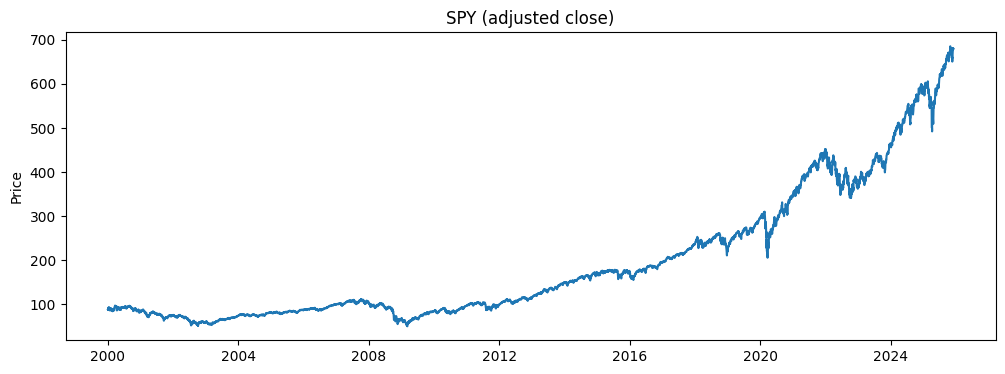

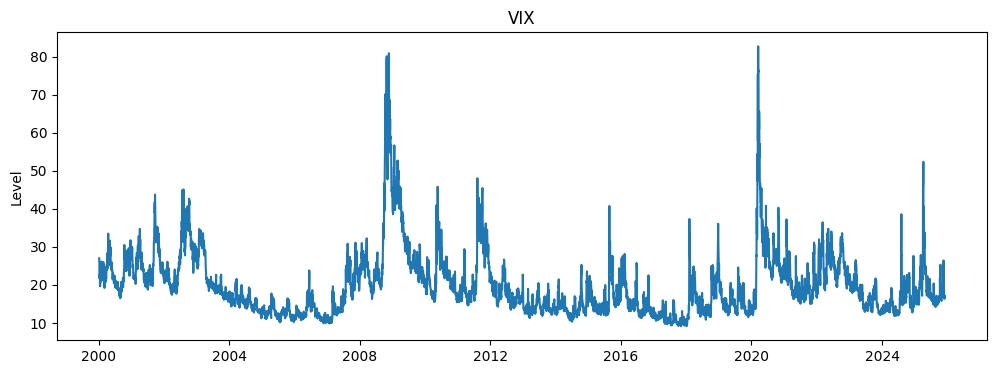

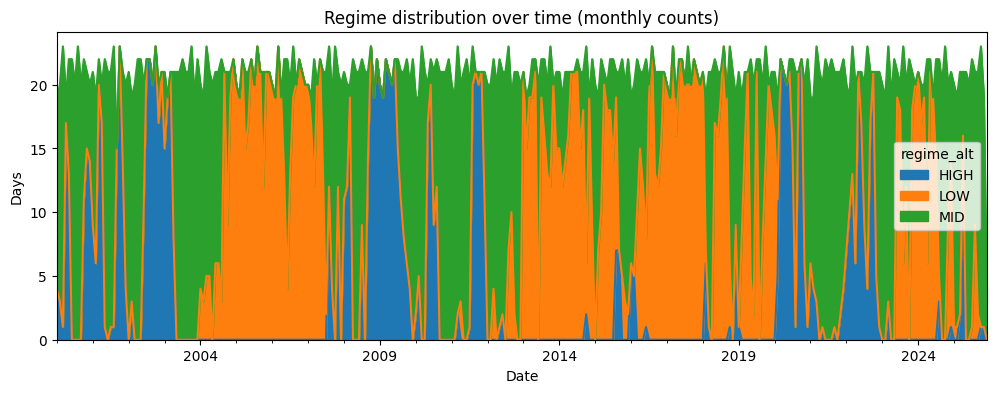

In [25]:
# CELL 9 — Visual inspection: SPY, VIX, and regimes

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df2.index, df2["spy"])
ax.set_title("SPY (adjusted close)")
ax.set_ylabel("Price")
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df2.index, df2["vix"])
ax.set_title("VIX")
ax.set_ylabel("Level")
plt.show()

# Regime as a stacked count over time (monthly)
reg_monthly = df2[REGIME_COL].groupby(pd.Grouper(freq="M")).value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(12, 4))
reg_monthly.plot(kind="area", ax=ax)
ax.set_title("Regime distribution over time (monthly counts)")
ax.set_ylabel("Days")
plt.show()


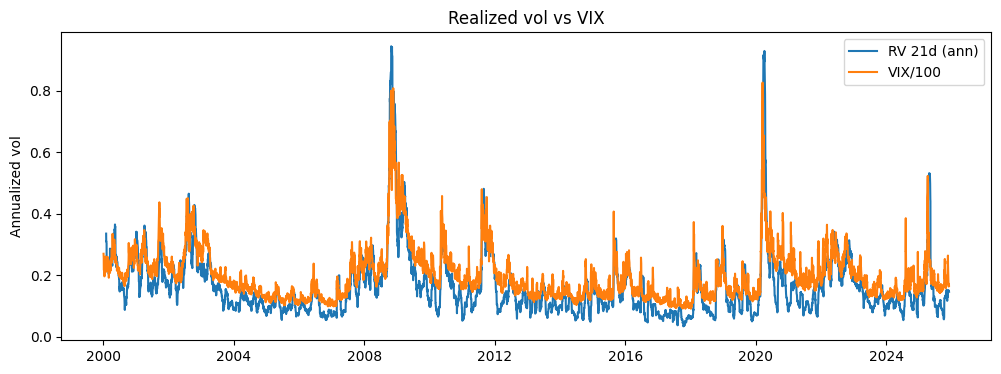

In [26]:
# CELL 10 — Add realized vol features (equity realized vol) and compare to VIX
# This is useful if you want to build a richer "equity vol regime" than VIX-only.

RV_WINDOW = 21  # 1m realized vol
df2["rv_21"] = df2["ret"].rolling(RV_WINDOW).std() * np.sqrt(252)  # annualized realized vol
df2["vix_pct"] = df2["vix"] / 100.0

# sanity plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df2.index, df2["rv_21"], label="RV 21d (ann)")
ax.plot(df2.index, df2["vix_pct"], label="VIX/100")
ax.set_title("Realized vol vs VIX")
ax.set_ylabel("Annualized vol")
ax.legend()
plt.show()


In [27]:
# CELL 11 — Build a simple regime overlay strategy (example)
# Idea: hold SPY with different exposure depending on regime.
# This is just a template—tune exposures, include transaction costs, etc.

EXPOSURE_MAP = {
    "LOW": 1.25,
    "MID": 1.00,
    "HIGH": 0.25,   # defensive in high vol
}

# Map exposures; if any unknown labels exist, default to 1.0
df2["exposure"] = df2[REGIME_COL].map(EXPOSURE_MAP).fillna(1.0)

# Strategy daily return
df2["strat_ret"] = df2["exposure"].shift(1) * df2["ret"]  # shift to avoid look-ahead
df2 = df2.dropna(subset=["strat_ret"])

def perf_stats(r: pd.Series, ann=252):
    r = r.dropna()
    mu = r.mean() * ann
    vol = r.std() * np.sqrt(ann)
    sharpe = np.nan if vol == 0 else mu / vol
    dd = (1 + r).cumprod()
    peak = dd.cummax()
    max_dd = (dd / peak - 1).min()
    return pd.Series({"ann_return": mu, "ann_vol": vol, "sharpe": sharpe, "max_drawdown": max_dd})

stats = pd.DataFrame({
    "SPY_buyhold": perf_stats(df2["ret"]),
    "Regime_overlay": perf_stats(df2["strat_ret"]),
}).T

display(stats)


,ann_return,ann_vol,sharpe,max_drawdown
SPY_buyhold,0.097863,0.194025,0.504382,-0.551894
Regime_overlay,0.070031,0.132817,0.527275,-0.452314


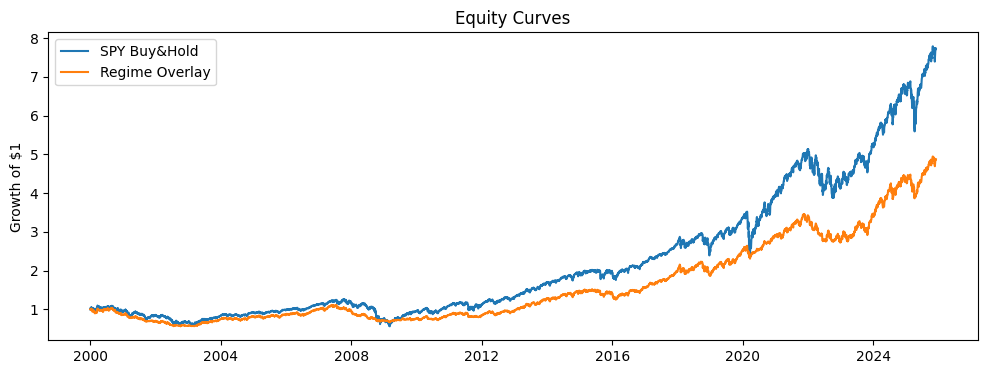

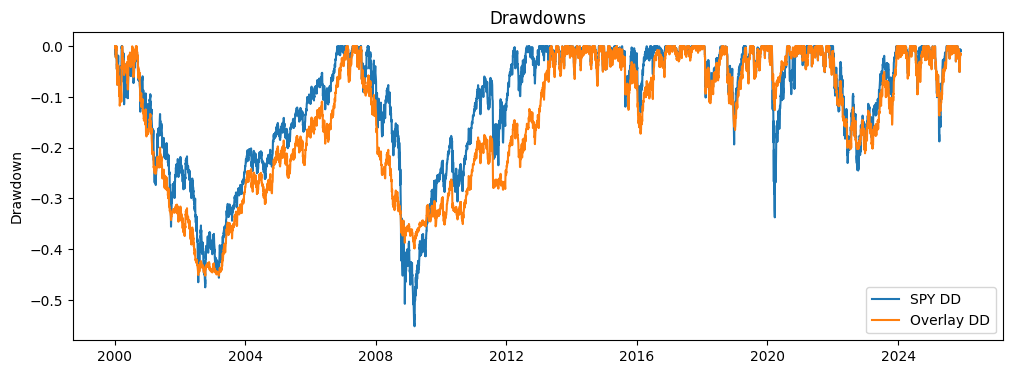

In [28]:
# CELL 12 — Equity curves + drawdowns

eq_spy = (1 + df2["ret"]).cumprod()
eq_strat = (1 + df2["strat_ret"]).cumprod()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df2.index, eq_spy, label="SPY Buy&Hold")
ax.plot(df2.index, eq_strat, label="Regime Overlay")
ax.set_title("Equity Curves")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.show()

# Drawdowns
dd_spy = eq_spy / eq_spy.cummax() - 1
dd_strat = eq_strat / eq_strat.cummax() - 1

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df2.index, dd_spy, label="SPY DD")
ax.plot(df2.index, dd_strat, label="Overlay DD")
ax.set_title("Drawdowns")
ax.set_ylabel("Drawdown")
ax.legend()
plt.show()


In [29]:
# CELL 13 — Conditional strategy performance by regime (what your framework is for)

cond = (
    df2
    .groupby(REGIME_COL)[["ret", "strat_ret"]]
    .agg(["mean", "std", "count"])
)
display(cond)

# Optional: annualize conditional means (approx)
cond_ann = pd.DataFrame(index=cond.index)
cond_ann["SPY_ann_mean"] = ((1 + cond[("ret","mean")]) ** 252) - 1
cond_ann["Overlay_ann_mean"] = ((1 + cond[("strat_ret","mean")]) ** 252) - 1
display(cond_ann)


ret                 strat_ret                
                mean       std count      mean       std count
regime_alt                                                    
HIGH       -0.001931  0.021907  1257 -0.001691  0.008029  1257
LOW         0.001520  0.005336  2080  0.001750  0.006413  2080
MID         0.000565  0.009746  3180  0.000093  0.009388  3180

,SPY_ann_mean,Overlay_ann_mean
regime_alt,,
HIGH,-0.385550,-0.347175
LOW,0.466138,0.553524
MID,0.153014,0.023828


In [30]:
# CELL 14 — Export clean artifacts (optional)
# Save df2 and summaries for reuse without re-running everything.

out_path = "vol_regime_df2.parquet"
df2.to_parquet(out_path)

summary_path = "regime_summary.csv"
summary.to_csv(summary_path)

print("Saved:", out_path, "and", summary_path)


Saved: vol_regime_df2.parquet and regime_summary.csv
